# NLP predict language from readme - Harry Potter

In [1]:
import acquire
import prepare
import wrangle
import explore
import model

explore.set_plotting_defaults()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Acquire

In [2]:
df = acquire.get_github_HPresults(cached=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  656 non-null    object
 1   content   656 non-null    object
dtypes: object(2)
memory usage: 10.4+ KB


# Prepare

In [4]:
df = prepare.prep_data(df, 'content', extra_words=['harry', 'potter', 'run', 'file', 'house'], exclude_words=[])

In [5]:
df.shape

(442, 7)

In [6]:
train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split(df, 'language')

In [7]:
X_train.shape, X_validate.shape, X_test.shape

((264, 6), (89, 6), (89, 6))

# Explore

In [8]:
# check balance of dataset for under/over sampling
explore.check_proportion(train_exp)
# balance is not bad, will not need to over/under sample

,n,percent
JavaScript,103,0.390152
Java,61,0.231061
Python,54,0.204545
HTML,46,0.174242


In [9]:
# create a list of words for each language category and remove single letter words
python_words, js_words, html_words, java_words = explore.create_lang_word_list(train_exp)
# get the count of words by category
python_freq, js_freq, html_freq, java_freq = explore.get_count_word_freq(python_words, js_words, html_words, java_words)

In [10]:
python_freq
# words to add to stopwords = harry, potter, file 

use           28
image         27
file          24
python        22
game          20
              ..
showcase       1
licenced       1
vim            1
namerename     1
envshtmplt     1
Length: 1280, dtype: int64

In [11]:
js_freq
# words to add to stopwords = harry, potter, run

build            327
app              301
npm              286
test             274
use              265
                ... 
readfall           1
texthogwarts'      1
caracter           1
lestranges         1
davis              1
Length: 4311, dtype: int64

In [12]:
html_freq
# words to add to stopwords = harry, potter, file, house

spell           21
&#9;            21
use             14
option          13
make            13
                ..
takenmean        1
lili             1
thanks           1
shellcottage     1
hp               1
Length: 1202, dtype: int64

In [13]:
java_freq
# words to add to stopwords = harry, potter, run, house

de                   189
build                143
test                 126
use                  123
npm                  120
                    ... 
npmrunallwatchcss      1
backallowing           1
overlay                1
letassociate           1
demand                 1
Length: 3440, dtype: int64

In [14]:
# Top 5 words for all languages are now unique

In [15]:
# combine list of word counts into df for further exploration
word_counts = explore.create_df_word_counts(python_freq, js_freq, html_freq, java_freq)
word_counts = explore.word_counts_proportion(word_counts)

In [16]:
word_counts

,Python,JavaScript,HTML,Java,all_words,prop_python,prop_js,prop_html,prop_java
&#9;,0,12,21,1,34,0.0,0.352941,0.617647,0.029412
&#9;content',0,1,1,0,2,0.0,0.500000,0.500000,0.000000
&#9;tag',0,1,1,0,2,0.0,0.500000,0.500000,0.000000
&#9;title',0,1,1,0,2,0.0,0.500000,0.500000,0.000000
000000,0,1,0,1,2,0.0,0.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...
zone,0,1,0,0,1,0.0,1.000000,0.000000,0.000000
zonko,0,1,0,0,1,0.0,1.000000,0.000000,0.000000
zum,0,0,0,1,1,0.0,0.000000,0.000000,1.000000
zusatzlich,0,0,0,1,1,0.0,0.000000,0.000000,1.000000


In [17]:
print("The number of words that occur n times: ")
word_counts['all_words'].value_counts().head(20)

The number of words that occur n times: 


1     2326
2      976
3      892
4      322
6      308
9      131
5      118
8      104
7       81
12      69
10      65
15      51
13      43
11      41
18      30
14      30
17      30
16      27
24      24
22      23
Name: all_words, dtype: int64

In [18]:
# filter out all words that occur less than 20 times
word_counts = word_counts[word_counts['all_words'] >= 20]
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 465 entries, &#9; to youre
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Python       465 non-null    int64  
 1   JavaScript   465 non-null    int64  
 2   HTML         465 non-null    int64  
 3   Java         465 non-null    int64  
 4   all_words    465 non-null    int64  
 5   prop_python  465 non-null    float64
 6   prop_js      465 non-null    float64
 7   prop_html    465 non-null    float64
 8   prop_java    465 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 36.3+ KB


<Figure size 864x576 with 0 Axes>

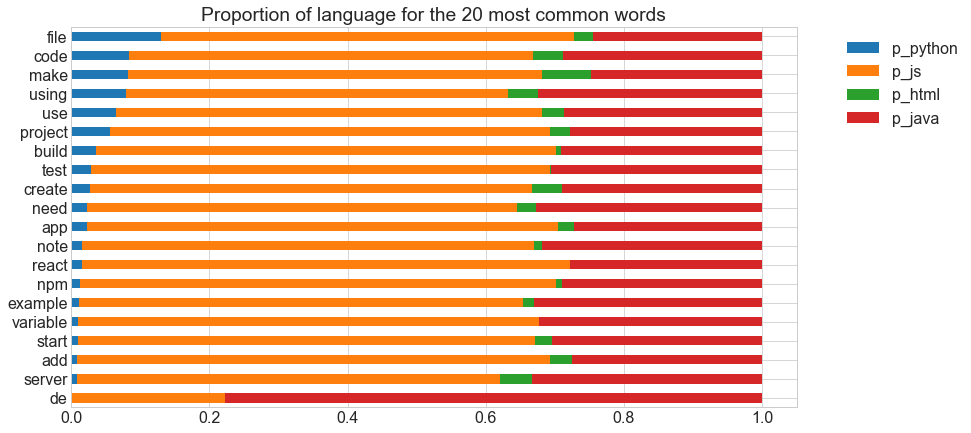

In [19]:
# visualize the % of the term in each language
explore.proportion_visualization(word_counts)

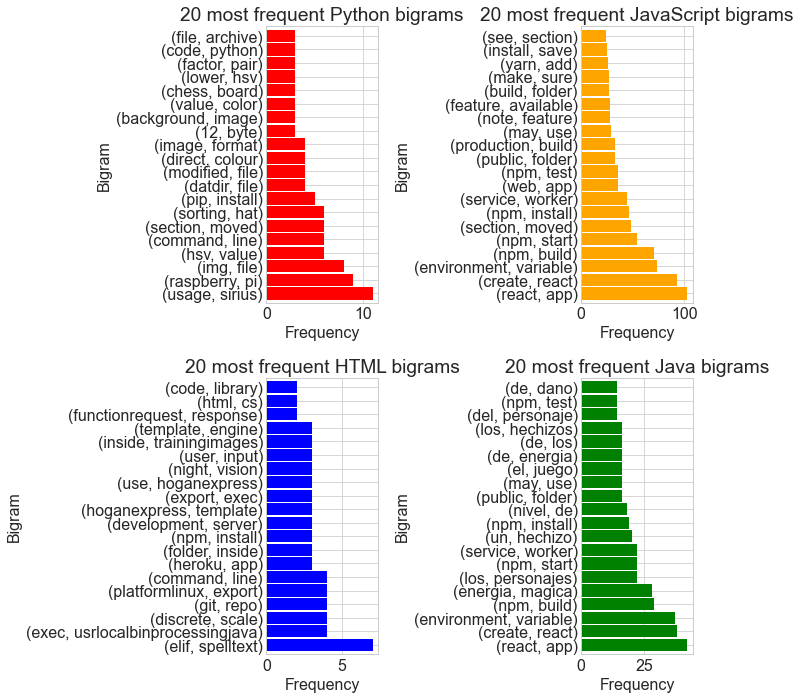

In [20]:
python_bigrams, js_bigrams, html_bigrams, java_bigrams = explore.create_bigrams(python_words, js_words, html_words, java_words)
explore.plot_bigrams(python_bigrams, js_bigrams, html_bigrams, java_bigrams)

# Model

In [21]:
# create vectorizers

# Bag of Words
vectorizer = CountVectorizer(stop_words='english', min_df=20, ngram_range=(1,2), binary=True)
# Learn vocabulary in sentences and Transform each sentences in vector space.
X_train_bow = vectorizer.fit_transform(X_train.lemmatized)
# Transform validate and test
X_val_bow = vectorizer.transform(X_validate.lemmatized)
X_test_bow = vectorizer.transform(X_test.lemmatized)

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', min_df=20, ngram_range=(1,2), binary=True)
X_train_tfidf = tfidf.fit_transform(X_train.lemmatized)
# Transform validate and test
X_val_tfidf = tfidf.transform(X_validate.lemmatized)
X_test_tfidf = tfidf.transform(X_test.lemmatized)

In [22]:
# Get Baseline - predict JavaScript for all
baseline = len(train_exp[train_exp.language == 'JavaScript']) / len(train_exp)
round(baseline,2)

0.39

## TRAIN
X_train.shape, X_validate.shape, X_test.shape 
((132, 6), (45, 6), (45, 6))  
X_train.shape, X_validate.shape, X_test.shape
  ((264, 6), (89, 6), (89, 6))


|FUNCTION            |VECTOR| F1 range | Accuracy |    |FUNCTION            |VECTOR| F1 range | Accuracy |    
|--------------------|------|----------|----------|    |--------------------|------|----------|----------|    
|Logistic Regression |BOW   |.37 to .68| .58      |    |Logistic Regression |BOW   |.25 to .68| .61      |    
|Logistic Regression |TFIDF |.37 to .67| .56      |    |Logistic Regression |TFIDF |.23 to .66| .58      |    
|Random Forest       |BOW   |.31 to .68| .59      |    |Random Forest       |BOW   |.12 to .64| .58      |    
|Random Forest       |TFIDF |.43 to .78| .68      |    |Random Forest       |TFIDF |.12 to .65| .59      |    
|ComplementNaiveBayes|TFIDF |.33 to .63| .54      |    |ComplementNaiveBayes|TFIDF |.42 to .67| .57      |    



In [23]:
# Logistic Regression
lm_bow, lm_tfidf = model.logistic_regression(X_train, y_train, X_train_bow, X_train_tfidf)

X_bow Accuracy: 61%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    HTML  Java  JavaScript  Python
language                                  
HTML           7     4          30       5
Java           1    28          30       2
JavaScript     2     4          94       3
Python         0     4          19      31

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.70      0.15      0.25        46
        Java       0.70      0.46      0.55        61
  JavaScript       0.54      0.91      0.68       103
      Python       0.76      0.57      0.65        54

    accuracy                           0.61       264
   macro avg       0.67      0.52      0.53       264
weighted avg       0.65      0.61      0.57       264

-----------------------
TF-IDF Accuracy: 58%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language           

In [24]:
rf_bow, rf_tfidf = model.random_forest(X_train, y_train, X_train_bow, X_train_tfidf)

X_bow Accuracy: 58%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    HTML  Java  JavaScript  Python
language                                  
HTML           3     2          39       2
Java           0    27          33       1
JavaScript     1     3          95       4
Python         0     0          27      27

-----------------------
X_bow Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.75      0.07      0.12        46
        Java       0.84      0.44      0.58        61
  JavaScript       0.49      0.92      0.64       103
      Python       0.79      0.50      0.61        54

    accuracy                           0.58       264
   macro avg       0.72      0.48      0.49       264
weighted avg       0.68      0.58      0.53       264

-----------------------
TF-IDF Accuracy: 59%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                 

In [25]:
# ComplementNB 
cnb_tfidf = model.complement_naive_bayes(X_train, y_train, X_train_tfidf)

TF-IDF Accuracy: 57%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                                  
HTML          28     6           8       4
Java          17    33           9       2
JavaScript    28    13          56       6
Python        15     3           3      33

-----------------------
TF-IDF Complement Niave Bayes Classification Report:
               precision    recall  f1-score   support

        HTML       0.32      0.61      0.42        46
        Java       0.60      0.54      0.57        61
  JavaScript       0.74      0.54      0.63       103
      Python       0.73      0.61      0.67        54

    accuracy                           0.57       264
   macro avg       0.60      0.58      0.57       264
weighted avg       0.63      0.57      0.58       264



## VALIDATE


|FUNCTION            |VECTOR| F1 range | Accuracy |     |FUNCTION            |VECTOR| F1 range | Accuracy |     
|--------------------|------|----------|----------|     |--------------------|------|----------|----------|     
|Logistic Regression |BOW   |.00 to .67| .47      |     |Logistic Regression |BOW   |.00 to .61| .53      |     
|Logistic Regression |TFIDF |.00 to .62| .44      |     |Logistic Regression |TFIDF |.00 to .65| .56      |     
|Random Forest       |BOW   |.00 to .62| .44      |     |Random Forest       |BOW   |.00 to .58| .47      |     
|Random Forest       |TFIDF |.00 to .62| .47      |     |Random Forest       |TFIDF |.00 to .60| .48      |     
|ComplementNaiveBayes|TFIDF |.21 to .67| .40      |     |ComplementNaiveBayes|TFIDF |.37 to .65| .52      |     



In [26]:
model.validate_logistic_regression(X_validate, y_validate, X_val_bow, X_val_tfidf, lm_bow, lm_tfidf)

X_bow Accuracy: 53%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    HTML  Java  JavaScript  Python
language                                  
HTML           0     1          13       2
Java           1     7          12       0
JavaScript     0     2          30       3
Python         0     0           8      10

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        16
        Java       0.70      0.35      0.47        20
  JavaScript       0.48      0.86      0.61        35
      Python       0.67      0.56      0.61        18

    accuracy                           0.53        89
   macro avg       0.46      0.44      0.42        89
weighted avg       0.48      0.53      0.47        89

-----------------------
TF-IDF Accuracy: 56%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language           

In [27]:
model.validate_random_forest(X_validate, y_validate, X_val_bow, X_val_tfidf, rf_bow, rf_tfidf)

X_bow Accuracy: 47%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    Java  JavaScript  Python
language                            
HTML           1          14       1
Java           4          15       1
JavaScript     3          31       1
Python         0          11       7

-----------------------
X_bow Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        16
        Java       0.50      0.20      0.29        20
  JavaScript       0.44      0.89      0.58        35
      Python       0.70      0.39      0.50        18

    accuracy                           0.47        89
   macro avg       0.41      0.37      0.34        89
weighted avg       0.43      0.47      0.40        89

-----------------------
TF-IDF Accuracy: 48%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  Java  JavaScript  Python
language                            
HTML           1          14  

In [28]:
model.validate_complement_naive_bayes(X_validate, y_validate, X_val_tfidf, cnb_tfidf)

TF-IDF Accuracy: 52%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  HTML  Java  JavaScript  Python
language                                  
HTML           9     2           4       1
Java           6     9           4       1
JavaScript    11     4          17       3
Python         7     0           0      11

-----------------------
TF-IDF Complement Niave Bayes Classification Report:
               precision    recall  f1-score   support

        HTML       0.27      0.56      0.37        16
        Java       0.60      0.45      0.51        20
  JavaScript       0.68      0.49      0.57        35
      Python       0.69      0.61      0.65        18

    accuracy                           0.52        89
   macro avg       0.56      0.53      0.52        89
weighted avg       0.59      0.52      0.54        89



## TEST


|FUNCTION            |VECTOR| F1 range | Accuracy |  |FUNCTION            |VECTOR| F1 range | Accuracy |  
|--------------------|------|----------|----------|  |--------------------|------|----------|----------|  
|Logistic Regression |BOW   |.00 to .67| .58      |  |Logistic Regression |BOW   |.12 to .72| .54      |  
|Random Forest       |TFIDF |.00 to .65| .58      |  |Random Forest       |TFIDF |.00 to .71| .53      |




In [29]:
model.test_logistic_regression(X_test, y_test, X_test_bow, lm_bow)

X_bow Accuracy: 54%

-----------------------
X_bow Confusion Matrix: 

 pred_bow    HTML  Java  JavaScript  Python
language                                  
HTML           1     0          12       2
Java           0     3          16       2
JavaScript     0     2          30       3
Python         1     0           3      14

-----------------------
X_bow Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.50      0.07      0.12        15
        Java       0.60      0.14      0.23        21
  JavaScript       0.49      0.86      0.62        35
      Python       0.67      0.78      0.72        18

    accuracy                           0.54        89
   macro avg       0.56      0.46      0.42        89
weighted avg       0.55      0.54      0.47        89



In [30]:
model.test_random_forest(X_test, y_test, X_test_tfidf, rf_tfidf)

TF-IDF Accuracy: 53%

-----------------------
TF-IDF Confusion Matrix: 

 pred_tfidf  Java  JavaScript  Python
language                            
HTML           0          15       0
Java           3          17       1
JavaScript     1          33       1
Python         0           7      11

-----------------------
TF-IDF Random Forest Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00        15
        Java       0.75      0.14      0.24        21
  JavaScript       0.46      0.94      0.62        35
      Python       0.85      0.61      0.71        18

    accuracy                           0.53        89
   macro avg       0.51      0.42      0.39        89
weighted avg       0.53      0.53      0.44        89

